In [1]:
from utils.config import *
from utils.utils import *
from utils.dataset import FoodDataset
from utils.model import FoodRecognitionModel
from utils.lr_finder import LRFinder

import numpy as np
import pandas as pd
import os
import cv2
import albumentations as A
from PIL import Image
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter

In [2]:
create_files(results_config.values())
save_logs(config, config['logs_path'])

#### Metadata

In [3]:
metadata = pd.read_csv(config['metadata_path']).drop(columns='Unnamed: 0')
cat_names = list(metadata.columns.values)
cat_names.remove('image_path')
cat_names.remove('class')
metadata = metadata.loc[:, ['image_path', 'class']]
data_path = config['data_path']

In [4]:
if config['debug']:
    metadata = metadata.iloc[: 3000]

train_size = int(4 / 5 * metadata.shape[0]) # 80%

train_metadata = metadata.iloc[: train_size]
valid_metadata = metadata.iloc[train_size + 1:].reset_index(drop=True)

#### Augmentations

In [5]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [6]:
train_augmentations = A.Compose([
    A.GaussianBlur(),
    A.ShiftScaleRotate(),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Resize(*config['image_size'])
])

valid_augmentations = A.Compose([
    A.Resize(*config['image_size'])
])

#### Dataloader

In [7]:
train_dataset = FoodDataset(train_metadata, image_transforms, cat_names, data_path, augmentations=train_augmentations)
valid_dataset = FoodDataset(valid_metadata, image_transforms, cat_names, data_path, augmentations=valid_augmentations)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=0)

#### Model

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [9]:
model = FoodRecognitionModel(models.resnet50(pretrained=True), len(cat_names))
model.to(device)
model.train()

for p in model.parameters():
    assert p.requires_grad == True
    assert p.is_cuda == True

In [10]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['lr'])
criterion = torch.nn.NLLLoss()

if config['lr_finder'] == False:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], epochs=config['num_epochs'], steps_per_epoch=len(train_loader))

In [11]:
if config['lr_finder']:
    lr_finder = LRFinder(model, optimizer, criterion)
    lr_finder.range_test(train_loader, end_lr=1, num_iter=100, start_lr=1e-6)
    lr_finder.plot()

In [12]:
writer = SummaryWriter(config['tensorboard_path'])

In [15]:
train_batch_ct = 0
valid_epoch = 0

#### Training

In [1]:
for epoch in trange(config['num_epochs']):
    model.train()
    for x, target, images in tqdm(train_loader, total=len(train_loader), desc='Train_' + str(epoch)):
        x = x.to(device)
        target = target.to(device)
        images = images.numpy()
        
        # clear gradients
        optimizer.zero_grad()
        
        output = model(x)
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        if train_batch_ct % config['valid_step'] == 0:
            validate(model, valid_loader, valid_epoch, criterion, writer, device, cat_names)
            save_model(valid_epoch, model, optimizer, config['checkpoints_path'])
            valid_epoch += 1
        
        if train_batch_ct % 200 == 0:
            gallery(images, plot_labels=False)            
            
        writer.add_scalar('Train/loss', loss.item(), train_batch_ct)
        writer.add_scalar('Train/lr', get_lr(optimizer), train_batch_ct)
        train_batch_ct += 1
        
        del loss, x, target, output

In [2]:
validate(model, valid_loader, valid_epoch, criterion, writer, device, cat_names)
save_model(valid_epoch, model, optimizer, config['checkpoints_path'])
valid_epoch += 1

#### Inference

In [17]:
test_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [18]:
_ = model.eval()

In [55]:
target_labels = []
output_labels = []

In [3]:
with torch.no_grad():
    for x, target, image in tqdm(test_loader, total=len(test_loader)):
        x = x.to(device)
        output = model(x).argmax().cpu().numpy()[0]
        target = target.numpy()[0]

        target_label = cat_names[target]
        output_label = cat_names[output]
        
        target_labels.append(target_label)
        output_labels.append(output_label)

        del x, output

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [58]:
cm = confusion_matrix(target_labels, output_labels)

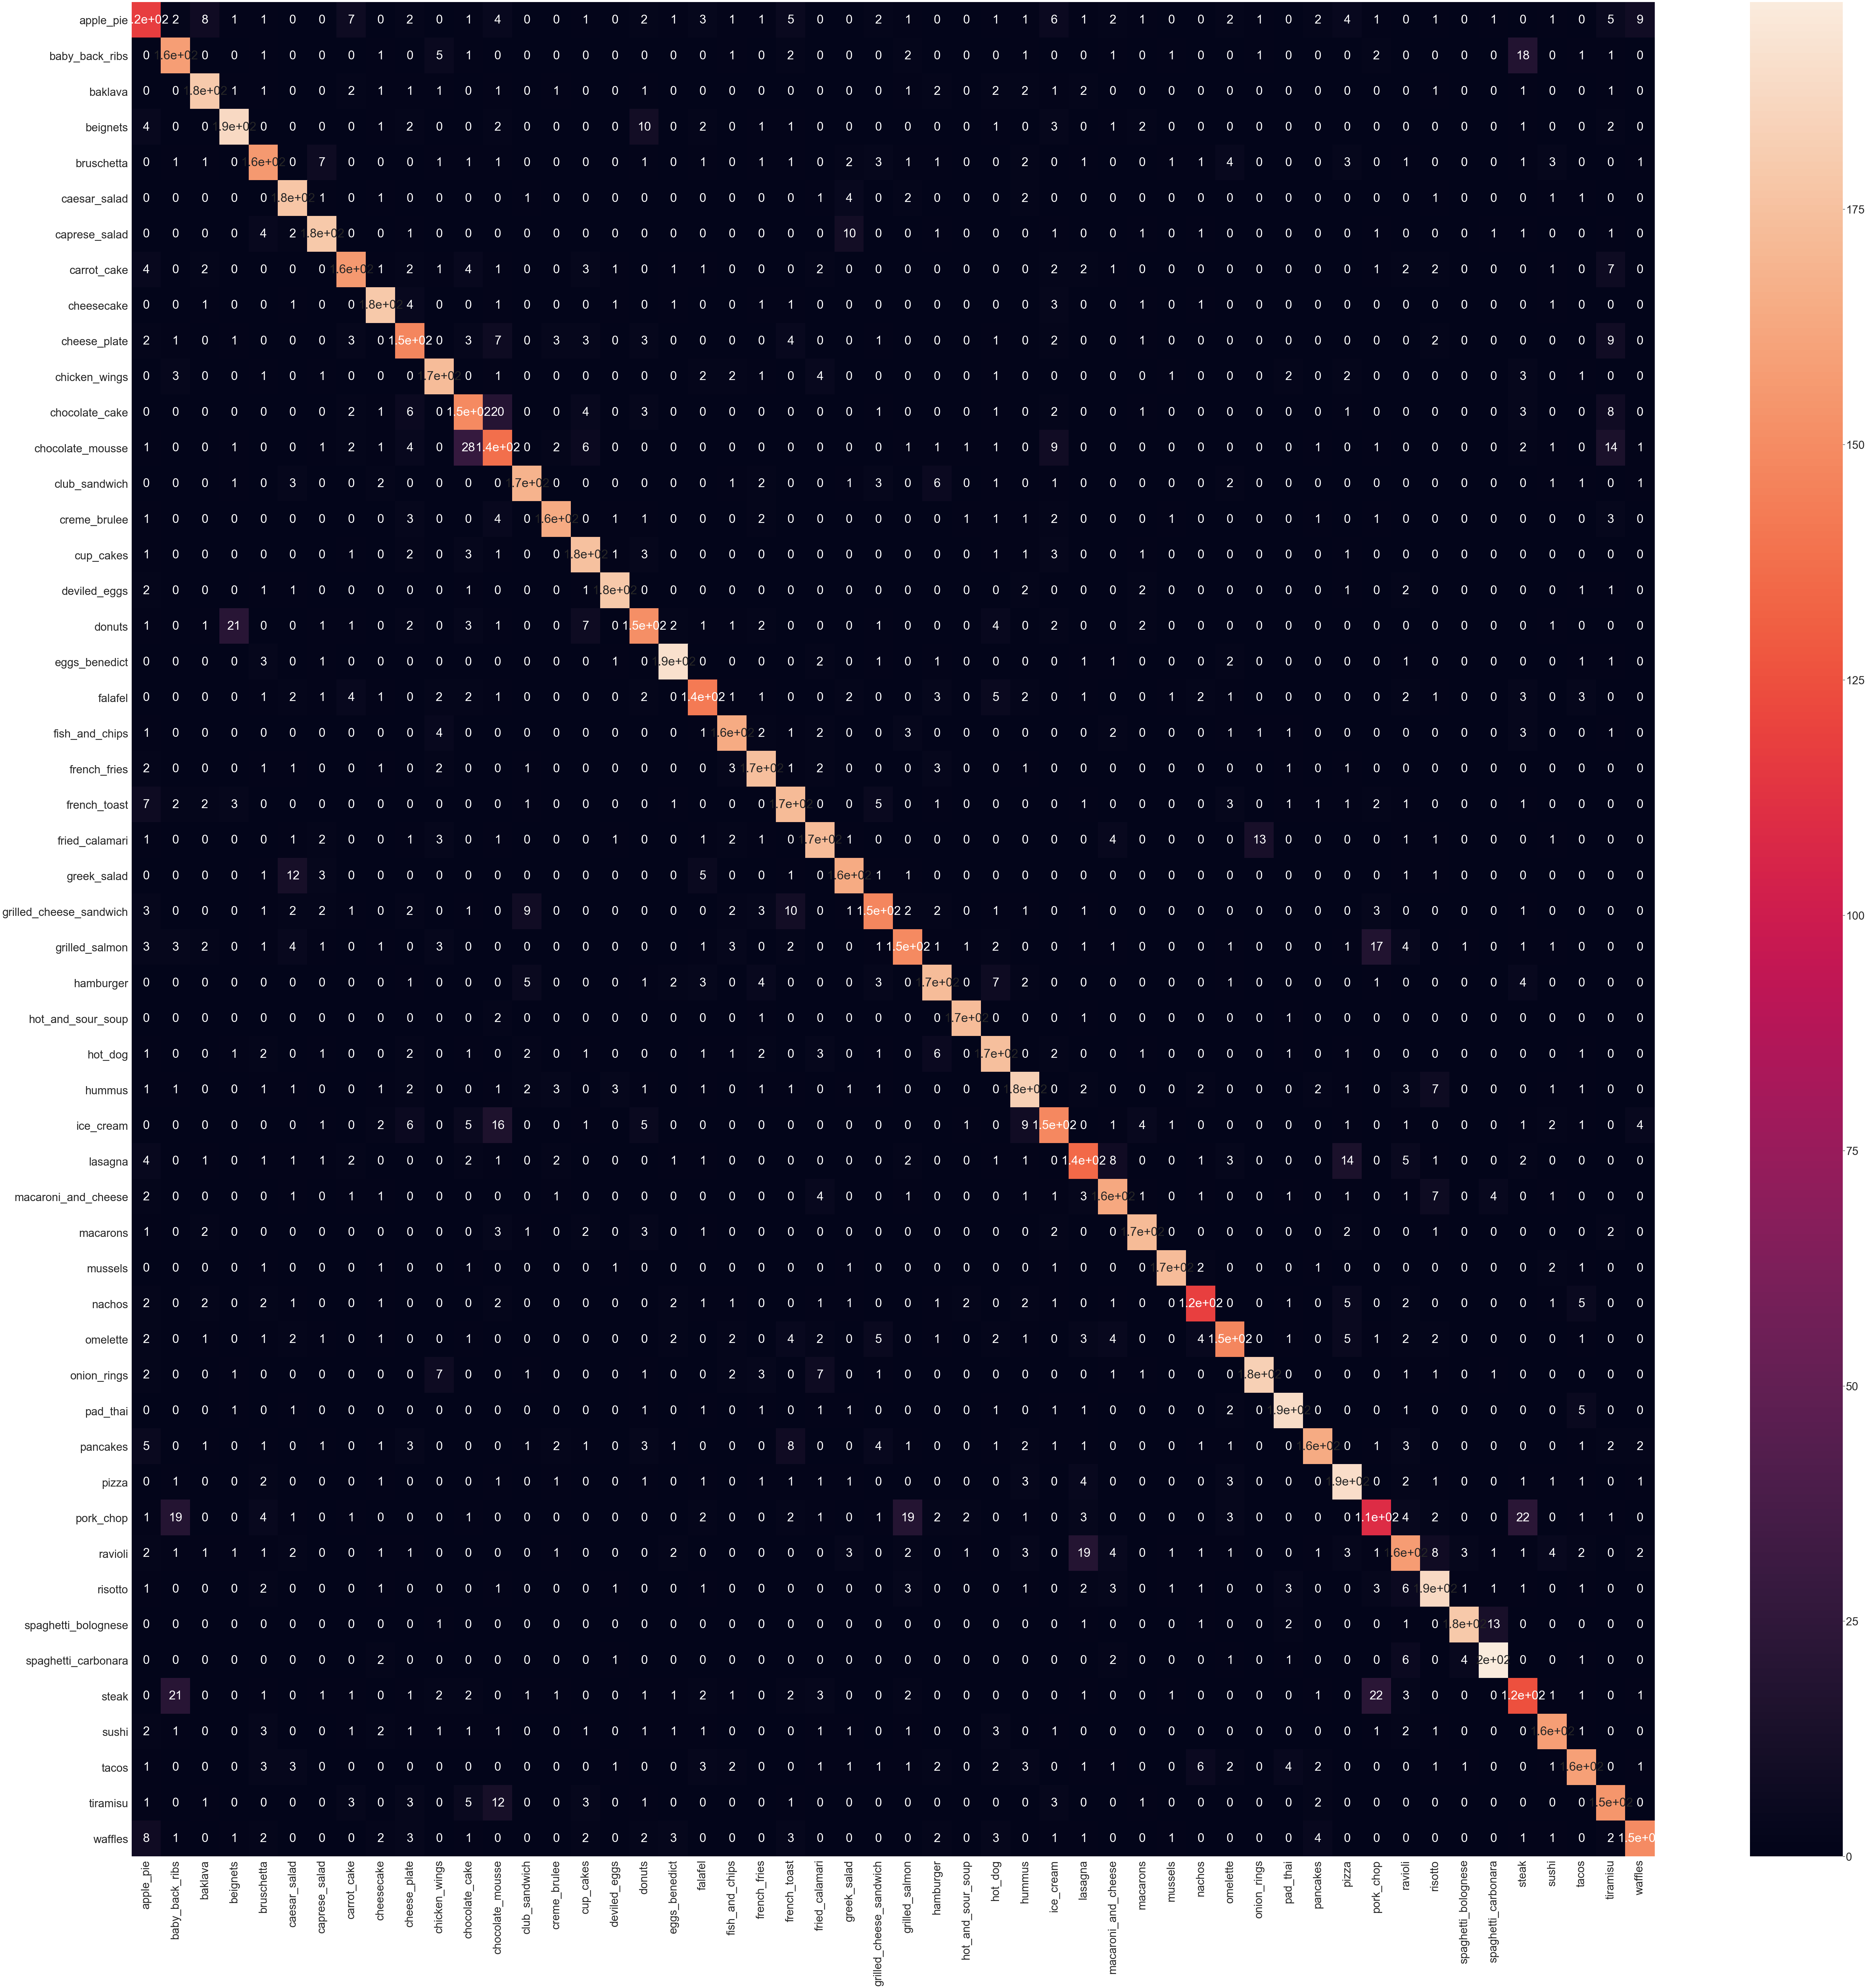

In [75]:
df_cm = pd.DataFrame(cm, cat_names, cat_names)
# plt.figure(figsize=(10,7))
fig = plt.figure(figsize=(100, 100))
sn.set(font_scale=3) # for label size
sn.heatmap(df_cm, annot=True) # font size
plt.show()